<a href="https://colab.research.google.com/github/mbhuiyan1/Statistical-Data-Mining-in-Python/blob/main/Climate_model_simulation_crashes_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
##########################################################
##                1. Data Preparation                   ##
##########################################################
# Load CSV file into the hr dataframe:
dat = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/untitled folder/PROJECT_6/pop_failures.csv')


In [6]:
# Inspect the data:
dat.head()
print(dat.shape)
print(dat.dtypes)

# Inspect data for missing values:
missing = dat.isnull()

# Print percentage of missing data:
missPercent = 100*missing.sum()/len(missing.index)
print('\nPercentage of missing data:')
print(missPercent)


(540, 21)
Study                     int64
Run                       int64
vconst_corr             float64
vconst_2                float64
vconst_3                float64
vconst_4                float64
vconst_5                float64
vconst_7                float64
ah_corr                 float64
ah_bolus                float64
slm_corr                float64
efficiency_factor       float64
tidal_mix_max           float64
vertical_decay_scale    float64
convect_corr            float64
bckgrnd_vdc1            float64
bckgrnd_vdc_ban         float64
bckgrnd_vdc_eq          float64
bckgrnd_vdc_psim        float64
Prandtl                 float64
outcome                   int64
dtype: object

Percentage of missing data:
Study                   0.0
Run                     0.0
vconst_corr             0.0
vconst_2                0.0
vconst_3                0.0
vconst_4                0.0
vconst_5                0.0
vconst_7                0.0
ah_corr                 0.0
ah_bolus               

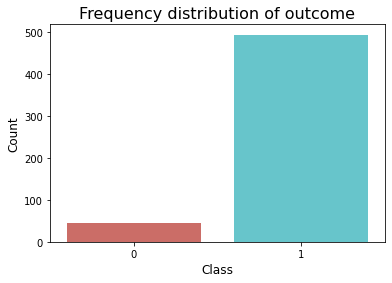

In [7]:
##########################################################
##            2. Exploratory Data Analysis              ##
##########################################################
# Default figsize: plt.rcParams['figure.figsize'] = (6.4,4.8)
# Frequency distribution of the target variable:
plt.figure()
sb.countplot(x='outcome',data=dat, palette='hls')
plt.ylabel('Count',size=12)
plt.xlabel('Class',size=12)
plt.title('Frequency distribution of outcome',fontsize=16)
plt.tick_params(axis='both',labelsize=10)

In [8]:
# Proportion of failed outcomes compared to succeed:
print(sum(dat['outcome']==0)/sum(dat['outcome']==1))

0.0931174089068826


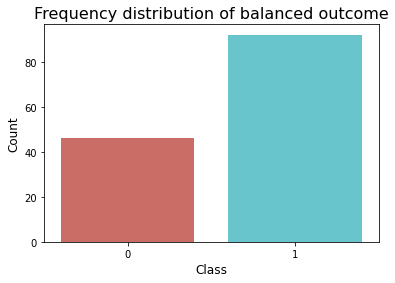

In [9]:
# Balancing the data by undersampling (2:1 proportion):
np.random.seed(0)
succ = dat[dat['outcome']==1]
usampl = succ.sample(2*sum(dat['outcome']==0))
datBal = pd.concat([usampl, dat[dat['outcome']==0]], axis=0)

# Frequency distribution of the balanced target variable:
plt.figure()
sb.countplot(x='outcome',data=datBal, palette='hls')
plt.ylabel('Count',size=12)
plt.xlabel('Class',size=12)
plt.title('Frequency distribution of balanced outcome',fontsize=16)
plt.tick_params(axis='both',labelsize=10)

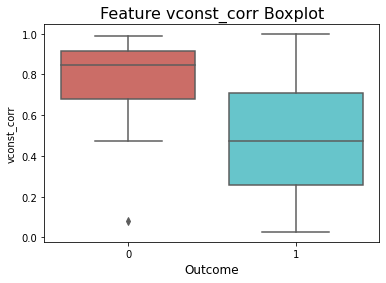

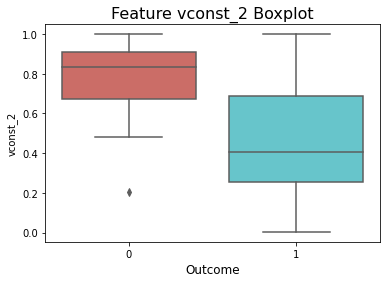

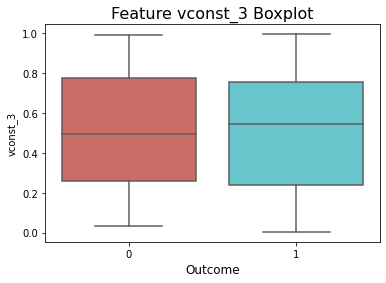

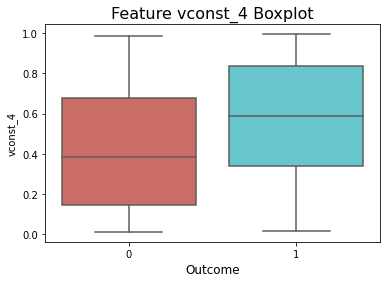

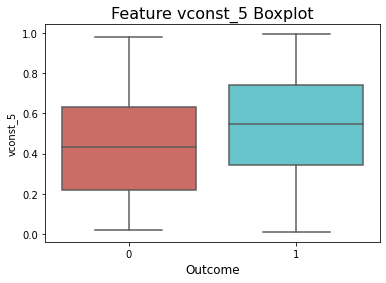

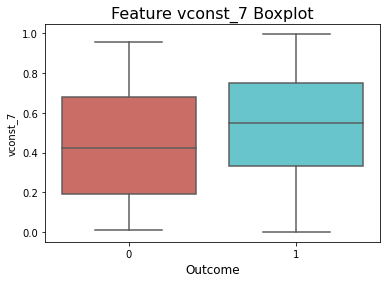

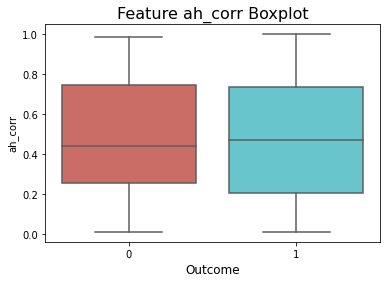

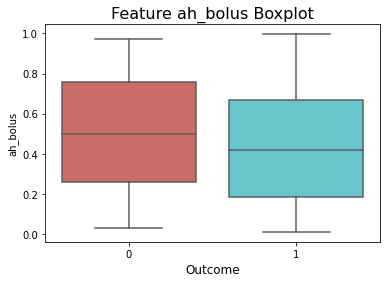

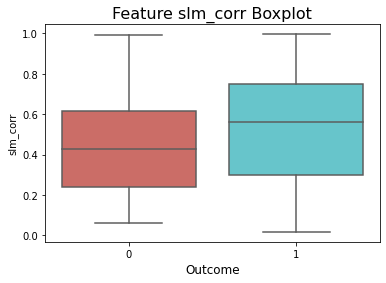

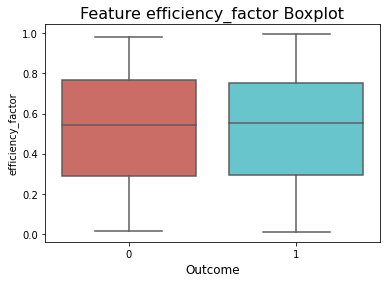

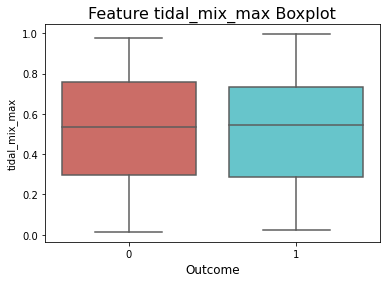

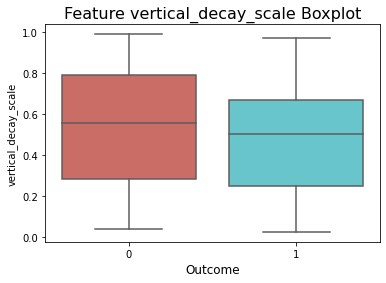

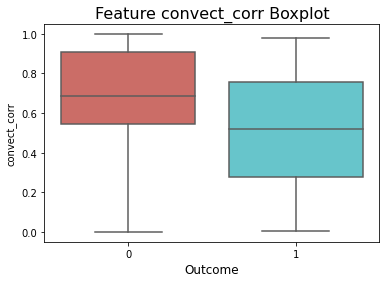

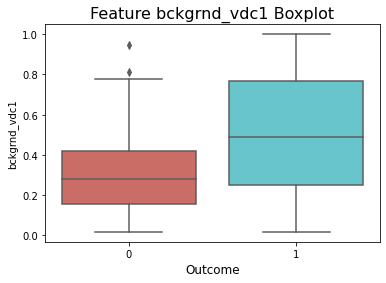

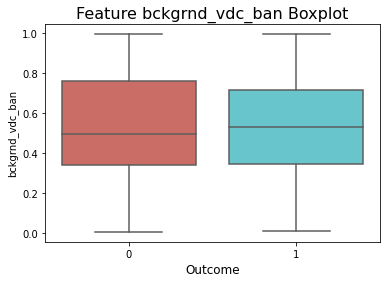

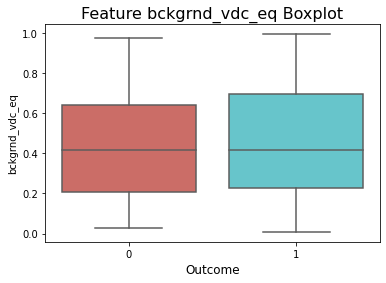

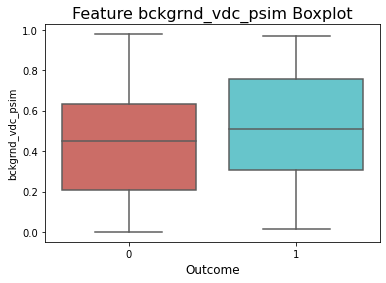

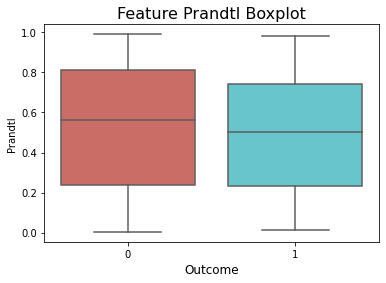

In [10]:
# Create boxplots to see the asociation between Class and other attributes:
for i in datBal.keys():
    if (datBal.dtypes[i] == np.float64):
        plt.figure()
        sb.boxplot(x='outcome', y=i, data=datBal, palette='hls')
        #plt.ylabel('Count',size=12)
        plt.xlabel('Outcome',size=12)
        plt.title('Feature '+i+' Boxplot',fontsize=16)
        plt.tick_params(axis='both',labelsize=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 <a list of 19 Text major ticklabel objects>)

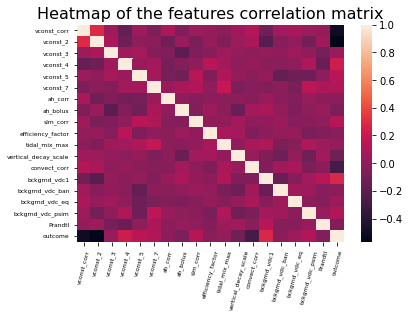

In [11]:
# Visualize correlation matrix:
corr = datBal.drop(['Run','Study'],1).corr()
plt.figure()
sb.heatmap(corr, annot=False, fmt='.2f')
plt.title('Heatmap of the features correlation matrix',fontsize=16)
plt.tick_params(axis='both',labelsize=6)
plt.xticks(rotation=75)

In [12]:
##########################################################
##                3. Data Partitioning                  ##
##########################################################
# Split the data into training set D1 and test set D2:
np.random.seed(5494)
rnd = np.random.binomial(size=len(datBal), n=1, p= 0.333)   # 2/3 zeroes, 1/3 ones
indxTr = np.nonzero(np.logical_not(rnd))
indxTs = np.nonzero(rnd)

# Drop Runs and Study IDs:
datBal = datBal.drop(['Study','Run'],1)

# Define train and test sets:
datTr = datBal.iloc[indxTr[0],:]
datTs = datBal.iloc[indxTs[0],:]

# Separate the features from the datasets:
xTr = datTr.drop(['outcome'],axis=1)
xTs = datTs.drop(['outcome'],axis=1)

# Separate the target variables from the datasets:
yTr = datTr['outcome']
yTs =  datTs['outcome']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # This is added back by InteractiveShellApp.init_path()


In [13]:
##########################################################
##               4. Logistic Regression                 ##
##########################################################
# Define several values for lambda:
myLambda = np.linspace(.0001,.05,500)   
myLambda = np.round(myLambda,4)
missRate = np.zeros((len(myLambda),))

for i in range(0,len(myLambda)):
    # alpha in python = lambda in R, and ElasticNet is Lasso when l1_ratio=1:
    lgst = SGDClassifier(loss="log", penalty="elasticnet", alpha=myLambda[i], l1_ratio=1)
    lgst.fit(xTr,yTr)
    pred = lgst.predict_proba(xTs)
    pred = pd.DataFrame(pred)
    pred = pred.drop(columns=[0])
    # Get the missclassification rate (percentage of  missclassified variables):
    missRate[i] = 1-accuracy_score(pred>.5,yTs)

# Get the best lambda:
optimInd = np.where(missRate==min(missRate))
if(len(optimInd[0])>1):
    optimInd = optimInd[0][0]
bestLambda = myLambda[optimInd]

# Get the best model:
bestModel = SGDClassifier(loss="log", penalty="elasticnet", alpha=bestLambda, l1_ratio=1)    
bestModel.fit(xTr,yTr)

# Get predictions and misclassification rate:
yHat = bestModel.predict_proba(xTs)
yHat = pd.DataFrame(yHat)
yHat = yHat.drop(columns=[0])
lgstMiss = np.around((1 - accuracy_score(yHat>.5,yTs))*100,decimals=2)
print(lgstMiss)

8.89


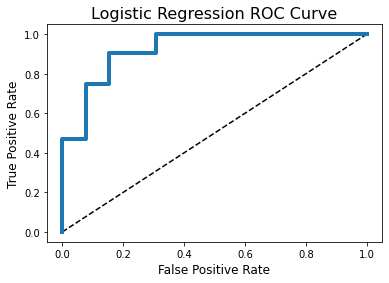

In [14]:
# Get the ROC curve:
fpr, tpr, thresh = roc_curve(yTs,yHat)
plt.figure()
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr,linewidth=4)
plt.xlabel('False Positive Rate',size=12)
plt.ylabel('True Positive Rate',size=12)
plt.title('Logistic Regression ROC Curve',fontsize=16)
plt.tick_params(axis='both',labelsize=10)

In [15]:
# Get the AUC metric:
lgstAUC = np.around(roc_auc_score(yTs,yHat),decimals=4)
print(lgstAUC)


0.9255


                      Coefficients
vconst_corr               0.154387
vconst_2                  0.231466
vconst_3                  0.021775
vconst_4                  0.054343
vconst_5                  0.047277
vconst_7                  0.034406
ah_corr                   0.015244
ah_bolus                  0.037247
slm_corr                  0.049847
efficiency_factor         0.038910
tidal_mix_max             0.040592
vertical_decay_scale      0.027304
convect_corr              0.111316
bckgrnd_vdc1              0.036000
bckgrnd_vdc_ban           0.028839
bckgrnd_vdc_eq            0.027423
bckgrnd_vdc_psim          0.028197
Prandtl                   0.015429


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text major ticklabel objects>)

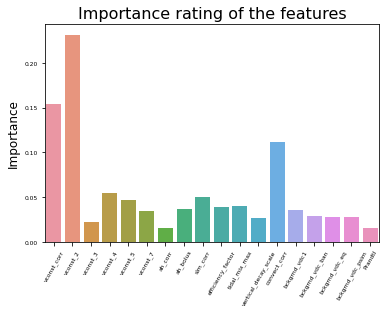

In [16]:
##########################################################
##                       5. RF                          ##
##########################################################
# Fit the model:
fst = RandomForestClassifier(random_state=5494)
fst.fit(xTr, yTr)

# Get features importance:
fstParam = pd.DataFrame(fst.feature_importances_,xTr.columns,columns=['Coefficients'])
print(fstParam)

# Plot features importance:
plt.figure()
sb.barplot(x=fstParam.index, y=fstParam['Coefficients'])
plt.ylabel('Importance',size=12)
plt.title('Importance rating of the features',fontsize=16)
plt.tick_params(axis='both',labelsize=6)
plt.xticks(rotation=60)

15.56


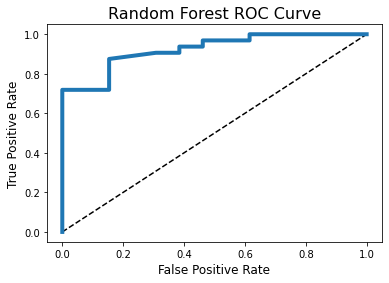

In [17]:
# Get predictions and misclassification rate:
yHat = fst.predict_proba(xTs)
yHat = pd.DataFrame(yHat)
yHat = yHat.drop(columns=[0])
fstMiss = np.around((1 - accuracy_score(yHat>.5,yTs))*100,decimals=2)
print(fstMiss)

# Get the ROC curve:
fpr, tpr, thresh = roc_curve(yTs,yHat)
plt.figure()
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr,linewidth=4)
plt.xlabel('False Positive Rate',size=12)
plt.ylabel('True Positive Rate',size=12)
plt.title('Random Forest ROC Curve',fontsize=16)
plt.tick_params(axis='both',labelsize=10)

In [18]:
# Get the AUC metric:
fstAUC = np.around(roc_auc_score(yTs,yHat),decimals=4)
print(fstAUC)



0.9231


In [ ]:
##########################################################
##                       6. ANN                         ##
##########################################################
# Define several values for layers and units:
minMiss = 1
for l in range(2,22):   # layers (1 to 20)
    for u in range(2,21):  # units (2 to 20)
        # define size for the model (no. of layers + 1, no. of units):
        sz = [l,u]
        # create model with the size combinations:
        ann = MLPClassifier(hidden_layer_sizes=sz,solver='lbfgs',random_state=5494)
        ann.fit(xTr, yTr)
        # make prediction and get current misclassif. rate:
        pred = ann.predict_proba(xTs)
        pred = pd.DataFrame(pred)
        pred = pred.drop(columns=[0])
        currMiss = 1-accuracy_score(pred>.5,yTs)
        # if we get a new minimum miss rate, update the best parameters:
        if currMiss<minMiss:
            bestSz = sz.copy()
            minMiss = currMiss
print(bestSz)

# Fit the best model: 
ann = MLPClassifier(hidden_layer_sizes=bestSz,solver='lbfgs',random_state=5494)
ann.fit(xTr, yTr)

# Get predictions and misclassification rate:
yHat = ann.predict_proba(xTs)
yHat = pd.DataFrame(yHat)
yHat = yHat.drop(columns=[0])
annMiss = np.around((1 - accuracy_score(yHat>.5,yTs))*100,decimals=2)
print(annMiss)

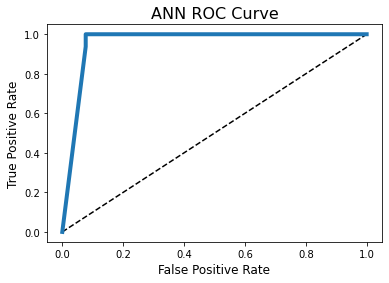

In [20]:
# Get the ROC curve:
fpr, tpr, thresh = roc_curve(yTs,yHat)
plt.figure()
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr,linewidth=4)
plt.xlabel('False Positive Rate',size=12)
plt.ylabel('True Positive Rate',size=12)
plt.title('ANN ROC Curve',fontsize=16)
plt.tick_params(axis='both',labelsize=10)

In [21]:
# Get the AUC metric:
annAUC = np.around(roc_auc_score(yTs,yHat),decimals=4)
print(annAUC)


0.9591


17.78
17.78
8.89
0.9062


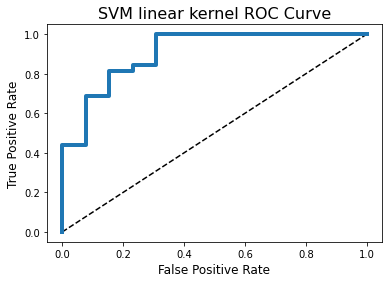

In [22]:
##########################################################
##                       7. SVM                         ##
##########################################################
# Fit the model using 3 different kernels:
svm1 = SVC(C=1,kernel='rbf',gamma='scale',random_state=5494,probability=True)
svm2 = SVC(C=2,kernel='poly',degree=3,gamma='scale',random_state=5494,probability=True)
svm3 = SVC(C=.5,kernel='linear',random_state=5494,probability=True)

svm1.fit(xTr, yTr)
svm2.fit(xTr, yTr)
svm3.fit(xTr, yTr)

# Get predictions and misclassification rate:
yHat1 = svm1.predict_proba(xTs)
yHat2 = svm2.predict_proba(xTs)
yHat3 = svm3.predict_proba(xTs)
yHat1 = pd.DataFrame(yHat1)
yHat2 = pd.DataFrame(yHat2)
yHat3 = pd.DataFrame(yHat3)
yHat1 = yHat1.drop(columns=[0])
yHat2 = yHat2.drop(columns=[0])
yHat3 = yHat3.drop(columns=[0])
svm1Miss = np.around((1 - accuracy_score(yHat1>.5,yTs))*100,decimals=2)
svm2Miss = np.around((1 - accuracy_score(yHat2>.5,yTs))*100,decimals=2)
svm3Miss = np.around((1 - accuracy_score(yHat3>.5,yTs))*100,decimals=2)
print(svm1Miss)
print(svm2Miss)
print(svm3Miss)

# Get the ROC curve for the best model:
fpr, tpr, thresh = roc_curve(yTs,yHat3)
plt.figure()
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr,linewidth=4)
plt.xlabel('False Positive Rate',size=12)
plt.ylabel('True Positive Rate',size=12)
plt.title('SVM linear kernel ROC Curve',fontsize=16)
plt.tick_params(axis='both',labelsize=10)
plt.savefig('9.svm.eps', format='eps', orientation='portrait', dpi=1024)

# Get the AUC metric:
svm3AUC = np.around(roc_auc_score(yTs,yHat3),decimals=4)
print(svm3AUC)

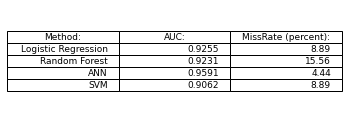

In [23]:
#########################################################
##                     8. Summary                       ##
##########################################################
# Create AUC measurements:
aucDat = {'Method:': ['Logistic Regression','Random Forest','ANN','SVM'], 
          'AUC:': [lgstAUC,fstAUC,annAUC,svm3AUC],
          'MissRate (percent):': [lgstMiss,fstMiss,annMiss,svm3Miss]}
auc = pd.DataFrame(aucDat)
# Create table with the prediction AUC measures:
fig, ax = plt.subplots(figsize=(6,2))
ax.axis('off'); ax.axis('tight')
ax.table(cellText=auc.values, colLabels=auc.columns, loc='center')